<a href="https://colab.research.google.com/github/mattshu0410/Peripheral-Blood-Deep-Learning/blob/main/PyTorch_WBC_Classifier_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18 White Blood Cells 

Based on the following tutorial:

*   https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#helper-functions
*   https://medium.com/temp08050309-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0



In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from PIL import Image
plt.ion()   # interactive mode

In [ ]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

     |████████████████████████████████| 275 kB 26.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=90c239b6d4812633d46d8fb92e9e16f5671999ed8d24893898020f89f43c6483
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

## Data Ingestion

How to split train, valid: https://medium.com/temp08050309-devpblog/pytorch-5-pytorch-visualization-splitting-dataset-save-and-load-a-model-501e0a664a67

The ratio of 80:20 chosen because it is industry-standard supposedly based on the Pareto principle.

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/PBC_dataset_normal_DIB_cropped_224.zip

In [ ]:
# Following loads images in batches and splits into trining and testing
data_dir = '/content/PBC_dataset_normal_DIB_cropped'
image_dataset = datasets.ImageFolder(root = data_dir,
                                     transform = transforms.Compose([#transforms.CenterCrop(224),
                                                                     #transforms.RandomHorizontalFlip(),
                                                                     transforms.ToTensor(), # Convert each (row, col, channel) from [0,255] to [0,1]
                                                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Using std & mean of ImageNet which pretrained ResNet is trained on
                                     ]))

len(image_dataset)

indices = np.arange(0, 16676)
np.random.shuffle(indices)

train = DataLoader(image_dataset,
                   batch_size = 4, # finite batch size reduces memory usage
                   num_workers=2, # multi-process data loading
                   sampler=torch.utils.data.SubsetRandomSampler(indices[:13300])
                   )
val = DataLoader(image_dataset,
                   batch_size = 4, # finite batch size reduces memory usage
                   num_workers=2, # multi-process data loading
                   sampler=torch.utils.data.SubsetRandomSampler(indices[-3376:])
                   )

dataloaders = {
    'train': train,
    'val': val
}

dataset_sizes = {
    'train': 13300,
    'val': 3376
}

class_names = image_dataset.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


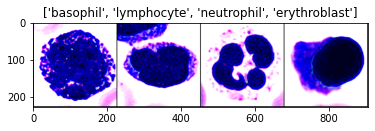

In [ ]:
# This returns 4 because the batch size earlier is 4
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
writer.add_image('training_wbc_images', out) # add wbc images to TensorBoard

## Training Model

There is an initial pre-trained model e.g. ResNet18 that is trained on ImageNet database. For every epoch there is a training and validation phase. For each training phase, a loss function is calculated based on prediction versus ground truth. Backpropagation then occurs to adjust the weights of the layers. The loss, accuracy and time taken for each epoch as well as the best model is also recorded.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                writer.add_scalar('training loss', epoch_loss, epoch) # track loss
                writer.add_scalar('accuracy', epoch_acc, epoch) # track accuracy

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Finetuning

Learning Rate Decay: https://arxiv.org/abs/1908.01878#:~:text=Learning%20rate%20decay%20(lrDecay)%20is,for%20training%20modern%20neural%20networks.&text=We%20provide%20another%20novel%20explanation,the%20learning%20of%20complex%20patterns.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features # 512 features passed into the final fully connected layer
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 8) # Replacing the last fully connected layer with input 512 features output 8 categories

writer.add_graph(model_ft, inputs) # plot model w/ example images

model_ft = model_ft.to(device) # device i.e. CPU/GPU
criterion = nn.CrossEntropyLoss() # Loss Function
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent adjusting parameters with set learning rate and momentum
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # Start with a larger learning rate and decay it by a factor of 0.1 every 7 epochs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

512


## Train & Evaluate


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)
writer.close()

Epoch 0/2
----------


100%|██████████| 3325/3325 [01:26<00:00, 38.61it/s]


train Loss: 0.3359 Acc: 0.8943


100%|██████████| 844/844 [00:14<00:00, 58.74it/s]


val Loss: 0.1222 Acc: 0.9588

Epoch 1/2
----------


100%|██████████| 3325/3325 [01:24<00:00, 39.58it/s]


train Loss: 0.1504 Acc: 0.9557


100%|██████████| 844/844 [00:13<00:00, 61.45it/s]


val Loss: 0.1162 Acc: 0.9665

Epoch 2/2
----------


100%|██████████| 3325/3325 [01:25<00:00, 39.11it/s]


train Loss: 0.1028 Acc: 0.9693


100%|██████████| 844/844 [00:14<00:00, 59.35it/s]


val Loss: 0.0890 Acc: 0.9716

Training complete in 4m 58s
Best val Acc: 0.971564


In [ ]:
torch.save(model_ft, '/content/best.pt')

## Evaluation & Visualisation

This shows a series of images from the validation portion of the dataset from Acevedo et. al. and the predictions that the classifier made.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


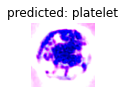

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


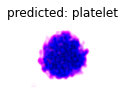

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


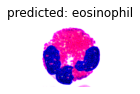

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


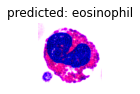

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


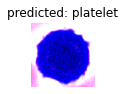

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


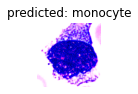

In [ ]:
visualize_model(model_ft)

## Testing on Unseen BCCD Examples

Test function obtained from: https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch

The testing dataset here was obtained by the following:


1.   Performed cropping of WBC from BCCD dataset using the bounding boxes generated by YOLOv5s (longest side of any rectangular bbox chosen to form square crop)
2.   Crops are then resized from their arbitrary dimensions e.g. 118 by 118 to 224 by 224.
3.   These images were then manually labelled by Dr Alex Wong

N.B. These images were not involved in any way in the training process and are entirely independent.


In [3]:
# Optionally load the model if you have it saved somewhere
model_path = "/content/best.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = torch.load(model_path, map_location=device)
if torch.cuda.is_available():
    model_ft.cuda()

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/BCCD_cropped_wbc_classified_test_set.zip

In [4]:
# Dataloader for test data
data_dir = '/content/BCCD_cropped_wbc_classified_test_set'
test_dataset = datasets.ImageFolder(root = data_dir,
                                    # Convert each (row, col, channel) from [0,255] to [0,1]
                                    transform = transforms.Compose([transforms.ToTensor()])
                                    )
test_loader = DataLoader(
    test_dataset,
    batch_size = 50,
    num_workers = 0,
    shuffle = False
)

### Temporary Note

The current issue is that the model seems to be very confident towards a single category for the vast majority of predictions. We did try this on a model trained on data with normalisation of training images. This yielded similar results of incorrect predictions.



https://stackoverflow.com/questions/44340848/how-to-convert-pytorch-autograd-variable-to-numpy

In [7]:
truelabels = []
predictions = []
model_ft.eval()

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.data.cpu().numpy() # Converting from GPU tensor to CPU numpy array
    truelabels.extend(labels) # Adding each batch of labels to the list of labels
    #print(model_ft(inputs))
    #print(torch.max(model_ft(inputs), 1))
    _, outputs = torch.max(model_ft(inputs), 1) # torch.max returns the maximum of each input tensor and the indices at which it is found (values, indices)
    outputs = outputs.cpu().numpy() # Converting from GPU tensor to CPU numpy array
    predictions.extend(outputs)

print(truelabels)
print(predictions)

bccd_dataset_cat = ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
acevedo_dataset_cat = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

for i, pred in enumerate(predictions):
  print(f"Image {i}:")
  print(f"Prediction: {acevedo_dataset_cat[pred]}")
  print(f"Truth: {bccd_dataset_cat[truelabels[i]]}")

# Build confusion matrix

#from sklearn.metrics import confusion_matrix
#import pandas as pd
#import seaborn as sns
#
#cf_matrix = confusion_matrix(truelabels, predictions)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
#                     columns = [i for i in class_names])
#plt.figure(figsize = (12,7))
#sns.heatmap(df_cm, annot=True)
#plt.savefig('output.png')



[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

## Explanation of Interpretation

Using LIME to mark out sections of the image that were predominantly used to reach the conclusion. LIME is model agnostic. 

In [ ]:
import torch.nn.functional as F

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]) 
    return transf    

preprocess_transform = get_preprocess_transform()


def batch_predict(images):
    model_ft.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ft.to(device)
    batch = batch.to(device)
    print(batch)
    logits = model_ft(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
img = Image.open("/content/BCCD_cropped_wbc_classified_test_set/basophil/BloodImage_00171_0.png")
test_pred = batch_predict([img])
test_pred.squeeze().argmax()

tensor([[[[1.0673, 1.0844, 1.1015,  ..., 0.9817, 0.9817, 0.9817],
          [1.0673, 1.0844, 1.1015,  ..., 0.9817, 0.9817, 0.9817],
          [1.0673, 1.0844, 1.1187,  ..., 0.9817, 0.9817, 0.9817],
          ...,
          [1.2557, 1.2557, 1.2557,  ..., 1.1872, 1.1872, 1.2043],
          [1.2557, 1.2557, 1.2557,  ..., 1.2728, 1.2557, 1.2557],
          [1.2214, 1.2214, 1.2214,  ..., 1.2385, 1.2557, 1.2385]],

         [[0.9055, 0.9230, 0.9405,  ..., 0.5903, 0.5903, 0.5728],
          [0.9055, 0.9230, 0.9405,  ..., 0.5903, 0.5903, 0.5728],
          [0.9055, 0.9230, 0.9580,  ..., 0.5903, 0.5903, 0.5728],
          ...,
          [1.4482, 1.4482, 1.4482,  ..., 1.0980, 1.1155, 1.1506],
          [1.4482, 1.4482, 1.4482,  ..., 1.1856, 1.2031, 1.2031],
          [1.4657, 1.4657, 1.4657,  ..., 1.1506, 1.1681, 1.1856]],

         [[1.0539, 1.0714, 1.1237,  ..., 1.0888, 1.1237, 1.1585],
          [1.0539, 1.0714, 1.1237,  ..., 1.0888, 1.1237, 1.1585],
          [1.0539, 1.1062, 1.1411,  ..., 1

5

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

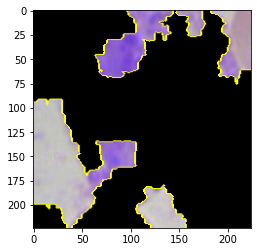

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

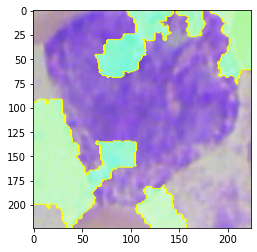

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)